In [1]:
import jax
import jax.numpy as jnp

In [3]:
#JAX is based on numpy, so uses its own Array class
x = jnp.arange(5)
print(isinstance(x, jax.Array))
print(x)

True
[0 1 2 3 4]


In [8]:
print(x.devices())
print(x.sharding)

{CpuDevice(id=0)}
SingleDeviceSharding(device=CpuDevice(id=0), memory_kind=unpinned_host)


In [14]:
#We can use JIT compilation to gain performance improvements on some code
def selu(x, alpha=1.67, lambda_=1.05):
    return lambda_*jnp.where(x>0, x, alpha * jnp.exp(x) - alpha)

selu_jit = jax.jit(selu)
print(selu(1), selu_jit(1))

%timeit selu(1)
%timeit selu_jit(1)

1.05 1.05
128 μs ± 6.52 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
13.5 μs ± 315 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [ ]:
#JAX uses tracers to stand-in for array objects, which are then passed to JAX functions to extract the sequence of encoded operations
@jax.jit
def f(x):
    print(x)
    return x+1

x = jnp.arange(5)
result = f(x)

Traced<ShapedArray(int32[5])>with<DynamicJaxprTrace>


In [16]:
#JAX uses its own intermediate representations for sequences of operations, jaxprs.
x = jnp.arange(5.0)
jax.make_jaxpr(selu)(x)

{ lambda ; a:f32[5]. let
    b:bool[5] = gt a 0.0
    c:f32[5] = exp a
    d:f32[5] = mul 1.6699999570846558 c
    e:f32[5] = sub d 1.6699999570846558
    f:f32[5] = pjit[
      name=_where
      jaxpr={ lambda ; g:bool[5] h:f32[5] i:f32[5]. let
          j:f32[5] = select_n g i h
        in (j,) }
    ] b a e
    k:f32[5] = mul 1.0499999523162842 f
  in (k,) }

In [18]:
#Pytrees are used to handle cases when we have a collection of arrays
params = [1,2, (jnp.arange(3), jnp.ones(2))]

print(jax.tree.structure(params))
print(jax.tree.leaves(params))

PyTreeDef([*, *, (*, *)])
[1, 2, Array([0, 1, 2], dtype=int32), Array([1., 1.], dtype=float32)]


In [19]:
# Dictionary of parameters
params = {'n': 5, 'W': jnp.ones((2, 2)), 'b': jnp.zeros(2)}

print(jax.tree.structure(params))
print(jax.tree.leaves(params))

PyTreeDef({'W': *, 'b': *, 'n': *})
[Array([[1., 1.],
       [1., 1.]], dtype=float32), Array([0., 0.], dtype=float32), 5]


In [21]:
# Named tuple of parameters
from typing import NamedTuple

class Params(NamedTuple):
  a: int
  b: float

params = Params(1, 5.0)
print(jax.tree.structure(params))
print(jax.tree.leaves(params))

PyTreeDef(CustomNode(namedtuple[Params], [*, *]))
[1, 5.0]


In [30]:
#JAX uses keys for generating random numbers
from jax import random

key = random.key(42)
print(key)

Array((), dtype=key<fry>) overlaying:
[ 0 42]


In [24]:
print(random.normal(key))
print(random.normal(key))
print(key)

-0.028304616
-0.028304616
Array((), dtype=key<fry>) overlaying:
[ 0 42]


In [31]:
for i in range(3):
  new_key, subkey = random.split(key)
  del key  # The old key is consumed by split() -- we must never use it again.

  val = random.normal(subkey)
  del subkey  # The subkey is consumed by normal().

  print(f"draw {i}: {val}")
  key = new_key  # new_key is safe to use in the next iteration.
  print(key)

draw 0: 0.6057640314102173
Array((), dtype=key<fry>) overlaying:
[1832780943  270669613]
draw 1: -0.21089035272598267
Array((), dtype=key<fry>) overlaying:
[1012194634 3152801799]
draw 2: -0.3948981463909149
Array((), dtype=key<fry>) overlaying:
[1773327481 1441649378]


In [ ]:
# JAX transforms functions by representing them as a sequence of primitive operations,
# each one representing a fundamental computation. These do not capture side-effects
# in the code, which is intentional. This can be complicated for impure functions,
# which are functions where all input is passed through the function arguments, and
# all output is returned through the function return value. They can lead to unexpected
# behavior. These are often not detected by JAX. This occurs as JAX works by wrapping
# each parameter in a tracer object, which tracks the operations performed on the
# parameter. This is used to produce the jaxpr. Also note that jaxprs only captures
# the function with the values of parameters given to it, i.e. if we have if-else
# statements in the function, the jaxpr will not capture the function with both
# branches of the if-else statement - only the one followed will be captured.

In [32]:
# The code below will send one operation at a time to the accelerator,
# limiting the ability of the compiler to optimise the code.
x = jnp.arange(1000000)
%timeit selu(x).block_until_ready()

8.73 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [34]:
# The code below will jit compile the function, allowing the compiler
# the receive more code and optimise it better.

selu_jit = jax.jit(selu)

# Pre-compile the function before timing...
selu_jit(x).block_until_ready()

%timeit selu_jit(x).block_until_ready()

2.43 ms ± 242 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
# Note, jit compilation cannot be used everywhere. For example, when we 
# use if statements or while loops without using parameter values to
# get a tracer (i.e. we can't use runtime values), we get errors. A workaround
# is to use jax.lax.cond, rewriting to avoid conditionals, or only jit
# compiling the parts of the code that don't have conditionals. If this
# must be done, we can pass a number of static arguments to the jit function,
# coming at the cost of having to be recompiled for every new input. 
# Often these are specified using functools' partial decorator.

In [35]:
#JAX can also be used for automatic vectorisation of functions.
# Consider the following function:

x = jnp.arange(5)
w = jnp.array([2,3,4])

def convolve(x,w):
    output = []
    for i in range(1, len(x)-1):
        output.append(jnp.dot(x[i-1:i+2], w))
    return jnp.array(output)

convolve(x,w)

Array([11, 20, 29], dtype=int32)

In [38]:
#Consider applying this to batches of inputs
xs = jnp.stack([x,x])
ws = jnp.stack([w,w])

# To do this, we could use a few methods. The most naive is to
# loop over the inputs, e.g.

def manually_batched_convolve(xs, ws):
  output = []
  for i in range(xs.shape[0]):
    output.append(convolve(xs[i], ws[i]))
  return jnp.stack(output)

print(manually_batched_convolve(xs, ws))
%timeit manually_batched_convolve(xs, ws)

[[11 20 29]
 [11 20 29]]
1.93 ms ± 57 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
# To make this more efficient, we could rewrite convolve so it
# is vectorised, and then apply it to the batched inputs.

def manually_vectorised_convolve(xs, ws):
    output = []
    for i in range(1, xs.shape[-1] -1):
        output.append(jnp.sum(xs[:, i-1:i+2] * ws, axis=1))
    return jnp.stack(output, axis=1)

print(manually_vectorised_convolve(xs, ws))
%timeit manually_vectorised_convolve(xs, ws)

[[11 20 29]
 [11 20 29]]
700 μs ± 33.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [40]:
# As we see, this is much faster than the previous implementation.
# However, this can take more effort and become messy, so JAX
# provides a way to automatically vectorise functions using the
# vmap function.

auto_vectorised_convolve = jax.vmap(convolve)

print(auto_vectorised_convolve(xs, ws))
%timeit auto_vectorised_convolve(xs, ws)

[[11 20 29]
 [11 20 29]]
2.28 ms ± 162 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [44]:
# Note, this assumes that the batch axis is the first axis, which
# can be changed using the in_axes and out_axes arguments. It also
# supports the case where only one input is batched, by setting
# the relevant term of in_axes to None. This is also compatible
# with jax.jit:

auto_vectorised_convolve_jit = jax.jit(jax.vmap(convolve))

print(auto_vectorised_convolve_jit(xs, ws))
%timeit auto_vectorised_convolve_jit(xs, ws)

manually_vectorised_convolve_jit = jax.jit(manually_vectorised_convolve)
print(manually_vectorised_convolve_jit(xs, ws))
%timeit manually_vectorised_convolve_jit(xs, ws)

[[11 20 29]
 [11 20 29]]
8.5 μs ± 95.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
[[11 20 29]
 [11 20 29]]
10.1 μs ± 661 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [45]:
#We can use JAX to perform differentiation with the grad function:

from jax import grad

grad_tanh = grad(jnp.tanh)
print(grad_tanh(1.0))

0.4199743


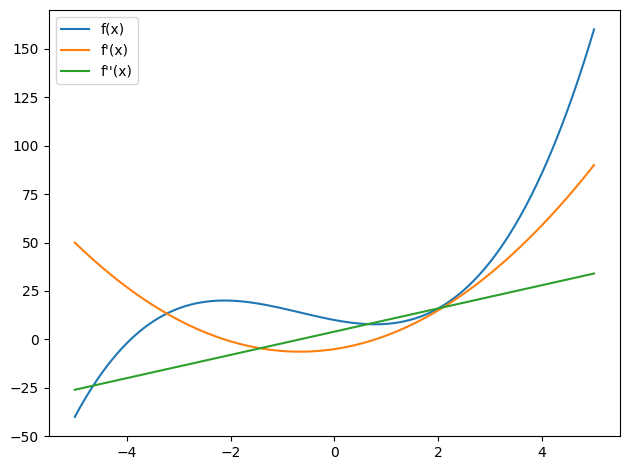

In [51]:
import matplotlib.pyplot as plt

def f(x):
    return x**3 + 2*x**2 - 5*x + 10

x = jnp.linspace(-5,5,100)
y = f(x)
dydx = jax.vmap(grad(f))(x)
d2ydx2 = jax.vmap(grad(grad(f)))(x)

plt.plot(x, y, label='f(x)')
plt.plot(x, dydx, label='f\'(x)')
plt.plot(x, d2ydx2, label='f\'\'(x)')
plt.legend()
plt.tight_layout()
plt.show()

In [52]:
#We can also use the grad function to compute gradients of functions with multiple arguments:
key = jax.random.key(0)

def sigmoid(x):
  return 0.5 * (jnp.tanh(x / 2) + 1)

# Outputs probability of a label being true.
def predict(W, b, inputs):
  return sigmoid(jnp.dot(inputs, W) + b)

# Build a toy dataset.
inputs = jnp.array([[0.52, 1.12,  0.77],
                    [0.88, -1.08, 0.15],
                    [0.52, 0.06, -1.30],
                    [0.74, -2.49, 1.39]])
targets = jnp.array([True, True, False, True])

# Training loss is the negative log-likelihood of the training examples.
def loss(W, b):
  preds = predict(W, b, inputs)
  label_probs = preds * targets + (1 - preds) * (1 - targets)
  return -jnp.sum(jnp.log(label_probs))

# Initialize random model coefficients
key, W_key, b_key = jax.random.split(key, 3)
W = jax.random.normal(W_key, (3,))
b = jax.random.normal(b_key, ())

In [53]:
# Differentiate `loss` with respect to the first positional argument:
W_grad = grad(loss, argnums=0)(W, b)
print(f'{W_grad=}')

# Since argnums=0 is the default, this does the same thing:
W_grad = grad(loss)(W, b)
print(f'{W_grad=}')

# But you can choose different values too, and drop the keyword:
b_grad = grad(loss, 1)(W, b)
print(f'{b_grad=}')

# Including tuple values
W_grad, b_grad = grad(loss, (0, 1))(W, b)
print(f'{W_grad=}')
print(f'{b_grad=}')

W_grad=Array([-0.43314594, -0.7354604 , -1.2598921 ], dtype=float32)
W_grad=Array([-0.43314594, -0.7354604 , -1.2598921 ], dtype=float32)
b_grad=Array(-0.6900177, dtype=float32)
W_grad=Array([-0.43314594, -0.7354604 , -1.2598921 ], dtype=float32)
b_grad=Array(-0.6900177, dtype=float32)


In [56]:
#JAX's use of pytrees means that we can differentiate with respect
# to dictionaries, tuples or lists:
def loss2(params_dict):
    preds = predict(params_dict['W'], params_dict['b'], inputs)
    label_probs = preds * targets + (1 - preds) * (1 - targets)
    return -jnp.sum(jnp.log(label_probs))

print(grad(loss2)({'W': W, 'b': b}))

{'W': Array([-0.43314594, -0.7354604 , -1.2598921 ], dtype=float32), 'b': Array(-0.6900177, dtype=float32)}


In [57]:
# We can use value_and_grad to get both the value of the function
# and the gradient at the same time:

loss_value, loss_grad = jax.value_and_grad(loss, (0,1))(W, b)
print(f'{loss_value=}')
print(f'{loss_grad=}')

loss_value=Array(2.9729187, dtype=float32)
loss_grad=(Array([-0.43314594, -0.7354604 , -1.2598921 ], dtype=float32), Array(-0.6900177, dtype=float32))


In [ ]:
# We can debug using jax.debug.print to print the actual runtime
# values. This works in combination with jax.vmap and jax.lax.map,
# though the order of printing in each is different.
# Breakpoints can be used to stop the running of code at a certain
# point and open a debug session. This can be used with conditionals
# through jax.lax.cond

In [ ]:
# jax.debug.callback can be used to have greater control over the
# host-side logic, byt calling a function. Thus, it is better for
# general purpose debugging.

In [60]:
#(Pseudo-)random number generation in JAX is one part of the code that
# is not compatible with the NumPy framework. NumPy uses mutations of
# the global state after each function call, 
import numpy as np
np.random.seed(0)
print(np.random.rand(3))

[0.5488135  0.71518937 0.60276338]


In [61]:
# Behind the scences, NumPy uses a Mersenne Twister PRNG, which is
# a stateful generator. 

def print_truncated_random_state():
  """To avoid spamming the outputs, print only part of the state."""
  full_random_state = np.random.get_state()
  print(str(full_random_state)[:460], '...')

print_truncated_random_state()

('MT19937', array([2443250962, 1093594115, 1878467924, 2709361018, 1101979660,
       3904844661,  676747479, 2085143622, 1056793272, 3812477442,
       2168787041,  275552121, 2696932952, 3432054210, 1657102335,
       3518946594,  962584079, 1051271004, 3806145045, 1414436097,
       2032348584, 1661738718, 1116708477, 2562755208, 3176189976,
        696824676, 2399811678, 3992505346,  569184356, 2626558620,
        136797809, 4273176064,  296167901, 343 ...


In [73]:
# We can see that the state is updated after each call
np.random.seed(0)
print_truncated_random_state()

np.random.seed(0)
np.random.normal()
print_truncated_random_state()

#These results are the same whether sampled individually or in batches

('MT19937', array([         0,          1, 1812433255, 1900727105, 1208447044,
       2481403966, 4042607538,  337614300, 3232553940, 1018809052,
       3202401494, 1775180719, 3192392114,  594215549,  184016991,
        829906058,  610491522, 3879932251, 3139825610,  297902587,
       4075895579, 2943625357, 3530655617, 1423771745, 2135928312,
       2891506774, 1066338622,  135451537,  933040465, 2759011858,
       2273819758, 3545703099, 2516396728, 127 ...
('MT19937', array([2443250962, 1093594115, 1878467924, 2709361018, 1101979660,
       3904844661,  676747479, 2085143622, 1056793272, 3812477442,
       2168787041,  275552121, 2696932952, 3432054210, 1657102335,
       3518946594,  962584079, 1051271004, 3806145045, 1414436097,
       2032348584, 1661738718, 1116708477, 2562755208, 3176189976,
        696824676, 2399811678, 3992505346,  569184356, 2626558620,
        136797809, 4273176064,  296167901, 343 ...


In [74]:
# JAX's approach is different. The aim of JAX is to make this process
# reproducible, parallelisable and vectorisable. Consider the following
# NumPy code:

import numpy as np

np.random.seed(0)

def bar(): return np.random.uniform()
def baz(): return np.random.uniform()

def foo(): return bar() + 2 * baz()

print(foo())

1.9791922366721637


In [78]:
# This output can only be reproducible if bar and baz are executed in
# a predictable order. This is fine in NumPy, but not in JAX as we 
# want to give the compiler the freedom to execute the code in any
# order it wants. Additionally, a global state would have to be
# synchronised across multiple devices, hampering parallelisation.
# To solve this, JAX uses explicit keys to track states:

from jax import random

key = random.key(42)
print(key)

Array((), dtype=key<fry>) overlaying:
[ 0 42]


In [79]:
# The key is an array of special dtype corresponding to the PRNG
# state. This is passed explicitly, so random functions consume
# the key but do not mutate it:

print(random.normal(key))
print(random.normal(key))

-0.028304616
-0.028304616


In [88]:
# Therefore, to get different outputs, we need to change the key
# after using it. JAX uses a Threefry counter-based PRNG, which
# is a stateless generator. They are splittable, so we can fork
# the key into new ones to use in parallel generation. The number
# of keys to split to can be specified as well. An example:
key = random.key(1)

for i in range(3):
  new_key, subkey = random.split(key)
  del key  # The old key is consumed by split() -- we must never use it again.

  val = random.normal(subkey)
  del subkey  # The subkey is consumed by normal().

  print(f"draw {i}: {val}")
  key = new_key  # new_key is safe to use in the next iteration.

draw 0: -0.24392002820968628
draw 1: 0.947751522064209
draw 2: 0.10954111069440842


In [ ]:
# JAX does not provide a sequential evidence guarantee as in NumPy
# (i.e. all at once vs in batches). This allows greater flexibility
# in writing our code, as we can e.g. vectorise it.

In [89]:
# A pytree is an object built out of container-like objects, e.g.
# lists of lists of dictionaries, dictionaries of lists, etc. A
# leaf in a pytree is any non-pytree object, but a single leaf is
# also a pytree. These can contain e.g. datasets, model parameters,
# optimiser state, etc.

# JAX provides a set of functions to work with pytrees, e.g. jax.tree_map:

import jax.numpy as jnp
import jax

list_of_lists = [[1, 2, 3], [4, 5], [6, 7, 8, 9]]

jax.tree.map(lambda x: x**2, list_of_lists)

[[1, 4, 9], [16, 25], [36, 49, 64, 81]]

In [90]:
# This can also take N-array functions over multiple arguments.
# The structure of the arguments must be the same: 
jax.tree.map(lambda x, y: x+y, list_of_lists, list_of_lists)

[[2, 4, 6], [8, 10], [12, 14, 16, 18]]

In [92]:
# As an example of using this in ML, consider the following:

import numpy as np

def init_mlp_params(layer_widths):
  params = []
  for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
    params.append(
        dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
             biases=np.ones(shape=(n_out,))
            )
    )
  return params

params = init_mlp_params([1, 128, 128, 1])
jax.tree.map(lambda x: x.shape, params) #Check shapes

[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

In [94]:
# Define the forward pass.
def forward(params, x):
  *hidden, last = params
  for layer in hidden:
    x = jax.nn.relu(x @ layer['weights'] + layer['biases'])
  return x @ last['weights'] + last['biases']

# Define the loss function.
def loss_fn(params, x, y):
  return jnp.mean((forward(params, x) - y) ** 2)

# Set the learning rate.
LEARNING_RATE = 0.0001

# Using the stochastic gradient descent, define the parameter update function.
# Apply `@jax.jit` for JIT compilation (speed).
@jax.jit
def update(params, x, y):
  # Calculate the gradients with `jax.grad`.
  grads = jax.grad(loss_fn)(params, x, y)
  # Note that `grads` is a pytree with the same structure as `params`.
  # `jax.grad` is one of many JAX functions that has
  # built-in support for pytrees.
  # This is useful - you can apply the SGD update using JAX pytree utilities.
  return jax.tree.map(
      lambda p, g: p - LEARNING_RATE * g, params, grads
  )

In [ ]:
# If new classes are defined, JAX considers these as pytree
# leaves unless explicitly registered. This requires some setup,
# but allows for more flexibility in the code. We can save on
# some of this by using inheritance from other classes, such
# as the NamedTuple class. Another way is using the @dataclass
# decorator from the dataclasses module, in combination with
# functools.partial on jax.tree_util.register_dataclass.

In [ ]:
# Each leaf of a pytree has a key path, so a key path for a
# leaf is a list of keys, with length equal to the depth of
# the leaf in the pytree. Each key is a hashable object, and
# depends on the type of object being looked at in the tree.
# JAX provides a few key types for dicts, lists and custom
# nodes.

In [ ]:
# See colab for info on parallel compuation in JAX.